In [23]:
import jax
import jax.numpy as np
import jax.random as jnp_random
import numpy as onp
from jax import grad, jacrev, jacfwd, jit, vmap, partial
from jax.scipy.special import logsumexp
from jax.numpy import concatenate as cat
import timeit

import random
import pickle as pkl
import scipy

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
@jit
def dist(x, s):
    dx = x-s
    return -0.5 * np.sum((dx/0.1)**2)

@jit
def p(x): # uniform distribution
    return 1.0

logexp_vmap = lambda _x, _s: logsumexp(vmap(dist, in_axes=(0,None))(_x, _s))

@jit
def KLergodic_loss(tr, si):
    logqi = vmap(partial(logexp_vmap, tr))(si)
    pi = vmap(p)(si)
    ell = -np.sum(logqi*pi) #+ np.mean(vmap(p)(si) * np.log(vmap(p)(si)))
    return ell

def fk(x, k):
    return np.prod(np.cos(np.pi*x*k))

fk_vmap = lambda _x, _k: vmap(fk, in_axes=(0,None))(_x, _k)

@jit
def fourier_ergodic_loss(tr, k):
    return np.mean(np.square(phik - np.mean(vmap(partial(fk_vmap,tr))(k),axis=1)))

In [19]:
log = {'method' : [], 'n' : [], 'elapsed time (s)' : []}

In [43]:
# n = 2
# test_N = [5, 10, 50, 100, 200, 300, 400, 500, 1000, 2000, 4000, 5000, 6000, 10000]
test_n = [2**i for i in range(10)]
N = 100
# n = 5
T = 100
num_k = 5

key=jnp_random.PRNGKey(0)
# for N in test_N:
for n in test_n:
    tr = jnp_random.uniform(key, minval=-1, maxval=1, shape=(T,n))
#     k  = jnp_random.randint(key,minval=0, maxval=10, shape=(num_k**n,n))
    si = jnp_random.uniform(key, minval=-1, maxval=1, shape=(N,n))
#     phik = jnp_random.normal(key, shape=(num_k**n,1))
    
#     fourier_ergodic_loss(tr,si)
    KLergodic_loss(tr,si)
    
    kl_time = timeit.timeit(lambda: KLergodic_loss(tr, si), number=1000)/1000.
    log['elapsed time (s)'].append(kl_time)
    log['method'].append('KL-Ergodic Measure')
    log['n'].append(n)
    print(kl_time)
#     fourier_time = timeit.timeit(lambda: fourier_ergodic_loss(tr, k), number=100)/100.
#     print(kl_time, fourier_time)

0.000381768835999992
0.00033481372299957004
0.00039775786200016227
0.00033496659899992666
0.00047014651500012404
0.000767939103000117
0.0013287892510002166
0.002079576430000088
0.0030961188599999334
0.004493961903000126


In [44]:
# n = 2
# test_N = [5, 10, 50, 100, 200, 300, 400, 500, 1000, 2000, 4000, 5000, 6000, 10000]
test_n = [i for i in range(1,15)]
N = 100
# n = 5
T = 100
num_k = 2

key=jnp_random.PRNGKey(0)
# for N in test_N:
for n in test_n:
    try:
        tr = jnp_random.uniform(key, minval=-1, maxval=1, shape=(T,n))
        k  = jnp_random.randint(key,minval=0, maxval=10, shape=(num_k**n,n))
    #     si = jnp_random.uniform(key, minval=-1, maxval=1, shape=(N,n))
        phik = jnp_random.normal(key, shape=(num_k**n,1))

        fourier_ergodic_loss(tr,k)
    #     KLergodic_loss(tr,si)

    #     kl_time = timeit.timeit(lambda: KLergodic_loss(tr, si), number=1000)/1000.
    #     log.append(kl_time)
        fourier_time = timeit.timeit(lambda: fourier_ergodic_loss(tr, k), number=100)/100.
        log['elapsed time (s)'].append(fourier_time)
        log['method'].append('Fourier Ergodic Metric')
        log['n'].append(n)
        print(fourier_time)
    except:
        print('errored out')

0.0004558108300034291
0.00047010990000217133
0.00025816033999944923
0.00024094087999856128
0.0003160543400008464
0.00044001054000091243
0.000983017240000663
0.0017395620999968741
0.003906350789998214
0.008696248560004277
0.021475392929996815
0.047581667490003386
0.1473100273900036
0.4833761894700001


In [51]:
df = pd.DataFrame(log)

In [49]:
sns.set()

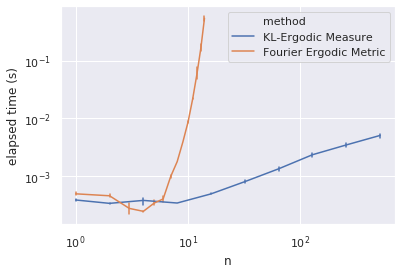

In [53]:
g = sns.lineplot(x="n", y="elapsed time (s)", hue="method", err_style="bars",markers=True, data=df)
g.set(yscale='log')
g.set(xscale='log')
plt.savefig('numerical_comparison.pdf')

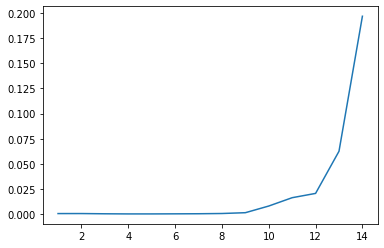

In [13]:
plt.plot(test_n[:len(log)], log)

In [9]:
test_n[:len(log)]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]